In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!!kaggle datasets download -d adityajn105/flickr8k

["Warning: Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /root/.kaggle/kaggle.json'",
 'Downloading flickr8k.zip to /content',
 '',
 '  0% 0.00/1.04G [00:00<?, ?B/s]',
 '  0% 5.00M/1.04G [00:00<00:36, 30.7MB/s]',
 '  3% 30.0M/1.04G [00:00<00:07, 136MB/s] ',
 '  5% 49.0M/1.04G [00:00<00:10, 99.1MB/s]',
 '  6% 61.0M/1.04G [00:00<00:11, 95.0MB/s]',
 '  8% 81.0M/1.04G [00:00<00:09, 112MB/s] ',
 '  9% 98.0M/1.04G [00:00<00:07, 128MB/s]',
 ' 11% 113M/1.04G [00:01<00:07, 135MB/s] ',
 ' 12% 127M/1.04G [00:01<00:08, 110MB/s]',
 ' 14% 149M/1.04G [00:01<00:07, 137MB/s]',
 ' 15% 164M/1.04G [00:01<00:07, 123MB/s]',
 ' 17% 178M/1.04G [00:01<00:09, 97.9MB/s]',
 ' 19% 197M/1.04G [00:01<00:07, 116MB/s] ',
 ' 20% 210M/1.04G [00:01<00:07, 120MB/s]',
 ' 21% 223M/1.04G [00:02<00:07, 121MB/s]',
 ' 23% 243M/1.04G [00:02<00:05, 143MB/s]',
 ' 24% 258M/1.04G [00:02<00:06, 131MB/s]',
 ' 27% 288M/1.04G [00:02<00:04, 177MB/s]',
 ' 29% 307M/1.04G [00:02<00:05, 14

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flickr8k.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import pickle
import numpy as np
from tqdm.auto import tqdm

from tensorflow .keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow .keras.preprocessing.image import load_img, img_to_array
from tensorflow .keras.preprocessing.text import Tokenizer
from tensorflow .keras.preprocessing.sequence import pad_sequences
from tensorflow .keras.models import Model
from tensorflow .keras.utils import to_categorical, plot_model
from tensorflow .keras.layers import Input, Embedding, LSTM, Dense, Dropout, add

In [ ]:
## extracting image features using vgg16
vggmodel = VGG16()
## restructuring the model
'''
Keep the Last Layer: If your task is similar to the original task the model was trained on (e.g., image classification), you might want to keep the last layer. It provides class probabilities that can be useful for direct classification.

Remove the Last Layer: If you want to use the pre-trained model as a feature extractor for a different task, you may want to remove the last layer. The output from the layer just before the final classification layer often captures more generic features that can be useful for various tasks.'''
vggmodel = Model(inputs=vggmodel.inputs, outputs=vggmodel.layers[-2].output)

print(vggmodel.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vggmodel.save('vggmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
## extract features from image
features = {}
directory = 'Images'

for img in tqdm(os.listdir(directory)):
    ## getting img path
    img_path = directory + '/' + img
    image = load_img(img_path, target_size=(224,224))
    ## converting to numpy array
    image_arr = np.array(image)
    # Reshape data for model
    image = image_arr.reshape((1,image_arr.shape[0], image_arr.shape[1], image_arr.shape[2])) # 3 dimensions bcs rgb
    ## pre process for vgg
    image = preprocess_input(image)
    ## extract features
    feature = vggmodel.predict(image, verbose=0)
    # get image id
    image_id = img.split('.')[0] # remove jpg from name
    ## store features
    features[image_id] = feature

In [ ]:
## storing features in pickle file
with open('features.pkl', 'wb') as file:
    pickle.dump(features, file)

In [ ]:
## loading features from pkl
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [ ]:
## loading captions
with open ('captions.txt') as f:
  next(f)
  file_contents = f.read()

In [ ]:
## making a dictionary of image to captions
mapping = {}

for line in tqdm(file_contents.split('\n')):
  tokens = line.split(',')  # tokens[0] = img, tokens[1] = capt
  img, capt = tokens[0], tokens[1: ]
  ## now removing jpg from img
  img = img.split('.')[0]
  # convert caption list to str
  caption = " ".join(capt)
  if img not in mapping:
    mapping[img] = []
  mapping[img].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [ ]:
len(mapping)

8092

In [ ]:
## pre process captions:
def clean(mapping):
  for  key, captions in mapping.items():  #key=img, captions = [c1,c2,c3..]
    for i in range(len(captions)):
      caption = captions[i]
      caption = caption.lower()
      # remove special caharcters and punc
      caption = caption.replace('[^A-Za-z]','')
      # remove extra spaces
      caption = caption.replace('\s+', ' ')
      # here caption is the entire sentence, so checking each word's length and removing single alphabets (eg : a little girl -> little girl)
      caption = " ".join([word for word in caption.split() if len(word)>1])
      # add start and end tags
      caption = 'start ' + caption + ' end'
      captions[i] = caption


In [ ]:
clean(mapping)

In [ ]:
mapping['1001773457_577c3a7d70']

['start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

In [ ]:
all_caption= []
for key in mapping:
  for caption in mapping[key]:
    all_caption.append(caption)

In [ ]:
len(all_caption)

40456

In [ ]:
all_caption

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end',
 'start little girl covered in paint sits in front of painted rainbow with her hands in bowl end',
 'start little girl is sitting in front of large painted rainbow end',
 'start small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end',
 'start there is girl with pigtails sitting in fro

In [ ]:
# pre processing captions
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(all_caption)

In [ ]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

8483

In [ ]:
max_length = max(len(caption.split()) for caption in all_caption)
max_length

35

In [ ]:
## train test split
img_ids = list(mapping.keys())
split = int(len(img_ids) * 0.80) # 80% training
train = img_ids[:split]
test = img_ids[split:]

In [ ]:
def data_generator(img_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in img_ids:
      n+=1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        # splitting into x,y pairs (x=my,y=name -> x= my name,y=is)
        for i in range(1,len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          ## pad input seq
          in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
          ## encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1,X2,y = np.array(X1), np.array(X2), np.array(y)
        yield [X1,X2],y
        X1, X2, y = list(), list(), list()
        n=0



In [ ]:
## model
# encoder
# image feature layers
inputs1 = Input(shape = (4096,)) # 4096 is output of vgg
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)
# sequence fetaure layers
inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer='adam')


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2171648   ['input_5[0][0]']             
                                                                                                  
 dropout_1 (Dropout)         (None, 4096)                 0         ['input_4[0][0]']             
                                                                                            

In [ ]:
# training
batch_size = 64
steps = len(train)//batch_size
epochs = 5

for i in range(epochs):
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for each epoch
  model.fit(generator, epochs =1, steps_per_epoch =steps, verbose=1)

101/101 [==============================] - 1068s 11s/step - loss: 3.3601


In [ ]:
model.save('captioning_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

model_path = 'captioning_model.h5'

# Load the model
model = load_model(model_path)


In [ ]:
def ind_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
def predict_caption(model,image, tokenizer, max_length):
  in_text = 'start '
  for i in range(max_length):
    # encode input seq
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    yhat = model.predict([image,sequence], verbose=0)
    yhat = np.argmax(yhat)
    # convert ind to word
    word = ind_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    in_text += ' '+word
    if word == 'end':
      break
  return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

def generate_caption(image_name):
    img_path = '/content/' + image_name
    image_id = image_name.split('.')[0]

    # Load the image using PIL
    img = Image.open(img_path)

    # Check if features for the image are already available
    if image_id in features:
        # Use existing features for prediction
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print(y_pred)
    else:
        # Getting img path
        image = load_img(img_path, target_size=(224, 224))
        # Converting to numpy array
        image_arr = np.array(image)
        # Reshape data for the model
        image = image_arr.reshape((1, image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]))  # 3 dimensions bcs rgb
        # Pre-process for VGG16
        image = preprocess_input(image)
        # Extract features
        feature = vggmodel.predict(image, verbose=0)
        # Store features
        features[image_id] = feature

        # Predict caption using the newly extracted features
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print(y_pred)

    # Display the image using Matplotlib
    plt.imshow(img)
    plt.show()


start  young girl is sitting on the floor end


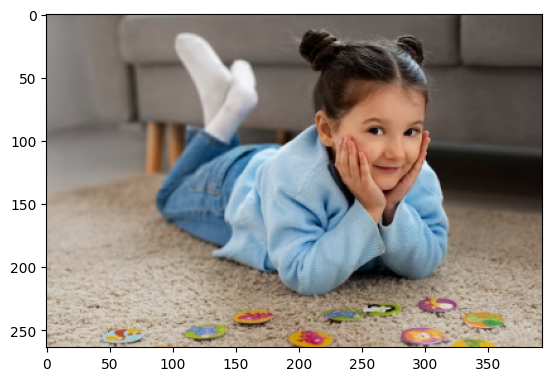

In [ ]:

generate_caption('Capture.PNG')
